# Detección de Incendios utilizando CNNs

In [5]:
!pip install torch torchvision datasets transformers matplotlib pandas scikit-learn pillow tqdm

!pip install --upgrade datasets


!!pip install kagglehub




['Requirement already satisfied: kagglehub in ./venv/lib/python3.12/site-packages (0.3.13)',
 'Requirement already satisfied: packaging in ./venv/lib/python3.12/site-packages (from kagglehub) (25.0)',
 'Requirement already satisfied: pyyaml in ./venv/lib/python3.12/site-packages (from kagglehub) (6.0.3)',
 'Requirement already satisfied: requests in ./venv/lib/python3.12/site-packages (from kagglehub) (2.32.5)',
 'Requirement already satisfied: tqdm in ./venv/lib/python3.12/site-packages (from kagglehub) (4.67.1)',
 'Requirement already satisfied: charset_normalizer<4,>=2 in ./venv/lib/python3.12/site-packages (from requests->kagglehub) (3.4.3)',
 'Requirement already satisfied: idna<4,>=2.5 in ./venv/lib/python3.12/site-packages (from requests->kagglehub) (3.10)',
 'Requirement already satisfied: urllib3<3,>=1.21.1 in ./venv/lib/python3.12/site-packages (from requests->kagglehub) (2.5.0)',
 'Requirement already satisfied: certifi>=2017.4.17 in ./venv/lib/python3.12/site-packages (from

In [2]:
# ===============================
# Importaciones
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor

import datasets

from datasets import load_dataset

import collections


import torchvision.models as models
import torch.nn as nn



from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

device = "cuda" if torch.cuda.is_available() else "cpu"



In [3]:

DATASET_DIR = r"/home/haru/Escritorio/CNNs_satelites/archive/the_wildfire_dataset_2n_version"


In [4]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((1024, 1024)) if img.size[0] * img.size[1] > 89478485 else img),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



train_ds = datasets.ImageFolder(os.path.join(DATASET_DIR, "train"), transform=transform)
val_ds   = datasets.ImageFolder(os.path.join(DATASET_DIR, "val"), transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print ("DATOS CLASE DE ENTRENAMIENTO")
print("=================================")
print("CLASES:", train_ds.classes)
print("Cantidad de imágenes:")
print("Train:", len(train_ds))
print("Val:",   len(val_ds))
print("Test:",  len(test_ds))
print("=================================")
print("DATOS CLASE DE TESTEO")
print("=================================")
print("CLASES:", test_ds.classes)
print("Cantidad de imágenes:")
print("Test:",  len(test_ds))
print("=================================")  
print("DATOS CLASE DE VALIDACION")
print("=================================")
print("CLASES:", val_ds.classes)
print("Cantidad de imágenes:")
print("Val:",  len(val_ds))
print("=================================")



DATOS CLASE DE ENTRENAMIENTO
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Train: 1887
Val: 402
Test: 410
DATOS CLASE DE TESTEO
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Test: 410
DATOS CLASE DE VALIDACION
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Val: 402


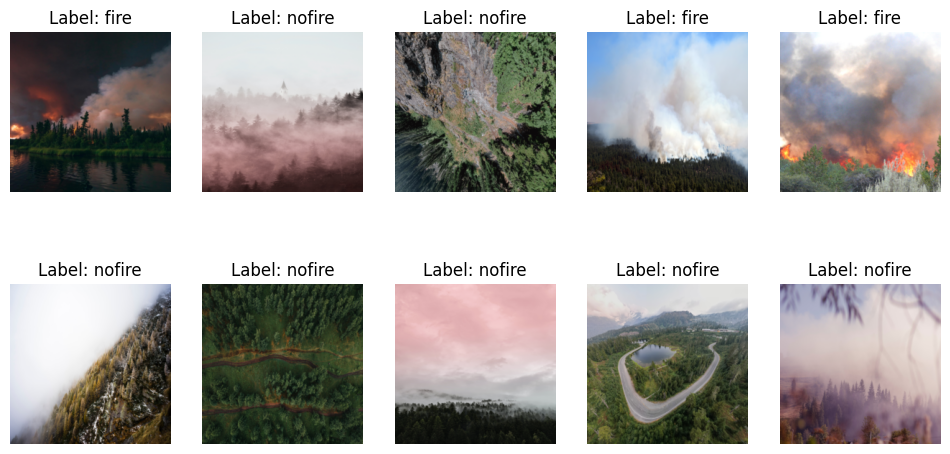

In [5]:
def show_random_images(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(f"Label: {dataset.classes[label]}")
        plt.axis("off")
    plt.show()


show_random_images(train_ds, n=10)


In [6]:


train_counts = collections.Counter([label for _, label in train_ds])
val_counts   = collections.Counter([label for _, label in val_ds])
test_counts  = collections.Counter([label for _, label in test_ds])

print("Distribución Train:", train_counts)
print("Distribución Val:", val_counts)
print("Distribución Test:", test_counts)


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBo

Distribución Train: Counter({1: 1157, 0: 730})
Distribución Val: Counter({1: 246, 0: 156})
Distribución Test: Counter({1: 251, 0: 159})


In [7]:
MODEL_DIR = r"/home/haru/Escritorio/CNNs_satelites/modelos"
os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:


def load_efficientnet(model_name="google/efficientnet-b0", num_labels=2):
    model_folder = os.path.join(MODEL_DIR, model_name.split("/")[-1])
    os.makedirs(model_folder, exist_ok=True)

    print(f"Cargando {model_name} en {model_folder} ...")

    # AutoImageProcessor
    processor = AutoImageProcessor.from_pretrained(model_name, cache_dir=model_folder)
    
    # Cargar modelo preentrenado tal cual (1000 clases)
    model = AutoModelForImageClassification.from_pretrained(
        model_name, cache_dir=model_folder
    )
    
    # Reemplazar la capa final con la cantidad de clases que necesitas
    in_features = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_features, num_labels)

    print(f"{model_name} cargado desde {model_folder}.")
    return model, processor

# Función para descargar y/o cargar un modelo torchvision
def load_torchvision_model(model_name="mobilenet_v3_small", num_labels=2):
    file_path = os.path.join(MODEL_DIR, f"{model_name}.pth")
    
    if os.path.exists(file_path):
        print(f"Cargando {model_name} desde {file_path} ...")
        if model_name == "mobilenet_v3_small":
            model = models.mobilenet_v3_small(pretrained=False)
            model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, num_labels)
        else:
            raise ValueError("Modelo no soportado")
        model.load_state_dict(torch.load(file_path))
    else:
        print(f"Descargando y guardando {model_name} en {file_path} ...")
        if model_name == "mobilenet_v3_small":
            model = models.mobilenet_v3_small(pretrained=True)
            model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, num_labels)
        else:
            raise ValueError("Modelo no soportado")
        torch.save(model.state_dict(), file_path)
    
    print(f"{model_name} listo para usar.")
    return model

In [15]:
import matplotlib.pyplot as plt

def plot_model_accuracies(results_dict, title="Comparación de Accuracy"):
    """
    Grafica los accuracies de diferentes modelos.
    
    Args:
        results_dict (dict): Diccionario con {nombre_modelo: accuracy}
        title (str): Título del gráfico
    """
    if not results_dict:
        print("No hay resultados para graficar.")
        return
    
    modelos = list(results_dict.keys())
    accuracies = list(results_dict.values())
    
    plt.figure(figsize=(max(6, len(modelos)*1.5),5))
    bars = plt.bar(modelos, accuracies, color=plt.cm.tab20.colors[:len(modelos)])
    
    plt.ylim(0,1)
    plt.ylabel("Accuracy")
    plt.title(title)
    
    # Agregar valor encima de cada barra
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.2f}", 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.show()


In [9]:
# 1️⃣ EfficientNet-B0
efficientnet_b0, extractor_b0 = load_efficientnet("google/efficientnet-b0")

# 2️⃣ EfficientNet-B5
#efficientnet_b5, extractor_b5 = load_efficientnet("google/efficientnet-b5")

# 3️⃣ MobileNetV3-Small
#mobilenet = load_torchvision_model("mobilenet_v3_small")

# 4️⃣ ResNet50
#resnet50 = load_torchvision_model("resnet50")

Cargando google/efficientnet-b0 en /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b0 ...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


google/efficientnet-b0 cargado desde /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b0.


In [10]:
efficientnet_b5, extractor_b5 = load_efficientnet("google/efficientnet-b5")

Cargando google/efficientnet-b5 en /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b5 ...
google/efficientnet-b5 cargado desde /home/haru/Escritorio/CNNs_satelites/modelos/efficientnet-b5.


In [11]:
mobilenet = load_torchvision_model("mobilenet_v3_small")

Cargando mobilenet_v3_small desde /home/haru/Escritorio/CNNs_satelites/modelos/mobilenet_v3_small.pth ...
mobilenet_v3_small listo para usar.


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
resnet50 = load_torchvision_model("resnet50")

Cargando resnet50 desde /home/haru/Escritorio/CNNs_satelites/modelos/resnet50.pth ...
resnet50 listo para usar.


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, device="cpu"):
    """
    Evalúa un modelo Hugging Face / PyTorch sobre un DataLoader.
    
    Args:
        model: modelo PyTorch o Hugging Face ya cargado
        dataloader: DataLoader con imágenes y etiquetas
        device: "cpu" o "cuda"
    
    Returns:
        accuracy (float), confusion_matrix (numpy array)
    """
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Para modelos Hugging Face, los logits están en outputs.logits
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, cm


In [14]:
# EfficientNet-B0
acc_b0, cm_b0 = evaluate_model(efficientnet_b0, train_loader, device=device)
print("EfficientNet-B0 - Train Accuracy:", acc_b0)
print("Confusion Matrix:\n", cm_b0)

# MobileNetV3-Small
acc_mn, cm_mn = evaluate_model(mobilenet, train_loader, device=device)
print("MobileNetV3-Small - Train Accuracy:", acc_mn)
print("Confusion Matrix:\n", cm_mn)

# ResNet50
acc_r50, cm_r50 = evaluate_model(resnet50, train_loader, device=device)
print("ResNet50 - Train Accuracy:", acc_r50)
print("Confusion Matrix:\n", cm_r50)

acc_b5,cm_b5 = evaluate_model(efficientnet_b5, train_loader, device = device)
print("EfficientNet-B5- Train Accuracy:", acc_b5)
print("Confusion Matrix:\n", cm_b5)

EfficientNet-B0 - Train Accuracy: 0.41865394806571277
Confusion Matrix:
 [[176 554]
 [543 614]]


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


MobileNetV3-Small - Train Accuracy: 0.5739268680445151
Confusion Matrix:
 [[  63  667]
 [ 137 1020]]


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ResNet50 - Train Accuracy: 0.5786963434022258
Confusion Matrix:
 [[168 562]
 [233 924]]


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


EfficientNet-B5- Train Accuracy: 0.4583995760466349
Confusion Matrix:
 [[501 229]
 [793 364]]


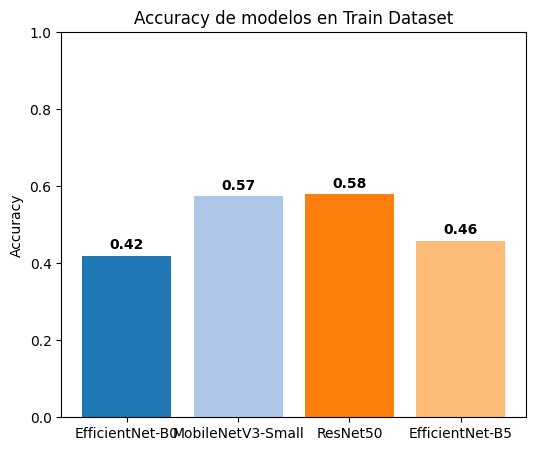

In [16]:
results = {
    "EfficientNet-B0": acc_b0,
    "MobileNetV3-Small": acc_mn,
    "ResNet50": acc_r50,
    "EfficientNet-B5": acc_b5
}

plot_model_accuracies(results, title="Accuracy de modelos en Train Dataset")


In [24]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

def train_last_layer(model, train_loader, val_loader, num_epochs=5, lr=1e-3, device="cuda"):
    model.to(device)

    # Congelar todas las capas
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar la última capa según tipo de modelo
    if hasattr(model, "classifier"):  # EfficientNet HF
        last_layer = model.classifier
    elif hasattr(model, "fc"):  # ResNet / torchvision
        last_layer = model.fc
    else:
        raise ValueError("No se pudo identificar la última capa del modelo.")

    for param in last_layer.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        model.train()
        total, correct = 0, 0
        running_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)

            # 👉 FIX: Convertir outputs a logits si es necesario
            if hasattr(outputs, "logits"):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        # ---------- VALIDACIÓN ----------
        model.eval()
        total, correct = 0, 0
        val_loss_accum = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)

                if hasattr(outputs, "logits"):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_loss_accum += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss = val_loss_accum / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

    return model, history


In [26]:
# Ejemplo con ResNet50
resnet50_ft, history_resnet50 = train_last_layer(resnet50, train_loader, val_loader, 
                                                num_epochs=5, lr=1e-3, device="cuda")


/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/5 | Train Acc: 0.8877 | Val Acc: 0.8582
Epoch 2/5 | Train Acc: 0.9009 | Val Acc: 0.8483
Epoch 3/5 | Train Acc: 0.8882 | Val Acc: 0.8532
Epoch 4/5 | Train Acc: 0.9168 | Val Acc: 0.8632
Epoch 5/5 | Train Acc: 0.9104 | Val Acc: 0.8731


In [27]:


EfficientNet_B5_ft, history_EfficientNet_B5 = train_last_layer(efficientnet_b5, train_loader, val_loader, 
                                                num_epochs=5, lr=1e-3, device="cuda")

Epoch 1/5 | Train Acc: 0.7377 | Val Acc: 0.8109
Epoch 2/5 | Train Acc: 0.8241 | Val Acc: 0.8085
Epoch 3/5 | Train Acc: 0.8410 | Val Acc: 0.7985
Epoch 4/5 | Train Acc: 0.8506 | Val Acc: 0.8060
Epoch 5/5 | Train Acc: 0.8537 | Val Acc: 0.8259


In [28]:

def plot_train_results(history):


    train_acc = history["train_acc"]
    val_acc   = history["val_acc"]

    print("Accuracy por epoch (entrenamiento):", train_acc)
    print("Accuracy por epoch (validación):", val_acc)

    # Accuracy final (última epoch)
    print("Train Accuracy final:", train_acc[-1])
    print("Validation Accuracy final:", val_acc[-1])

    import matplotlib.pyplot as plt

    epochs = range(1, len(train_acc)+1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evolución de Accuracy durante el entrenamiento")
    plt.legend()
    plt.show()


Accuracy por epoch (entrenamiento): [0.8876523582405935, 0.9009009009009009, 0.8881822999470058, 0.9167991520932698, 0.9104398516163222]
Accuracy por epoch (validación): [0.8582089552238806, 0.8482587064676617, 0.8532338308457711, 0.8631840796019901, 0.8731343283582089]
Train Accuracy final: 0.9104398516163222
Validation Accuracy final: 0.8731343283582089


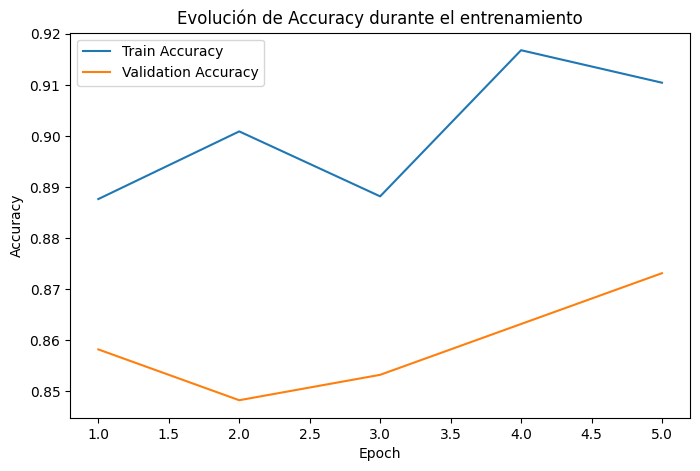

In [29]:
plot_train_results(history_resnet50)

Accuracy por epoch (entrenamiento): [0.7376788553259142, 0.8240593534711181, 0.8410174880763116, 0.8505564387917329, 0.8537360890302067]
Accuracy por epoch (validación): [0.8109452736318408, 0.8084577114427861, 0.7985074626865671, 0.8059701492537313, 0.8258706467661692]
Train Accuracy final: 0.8537360890302067
Validation Accuracy final: 0.8258706467661692


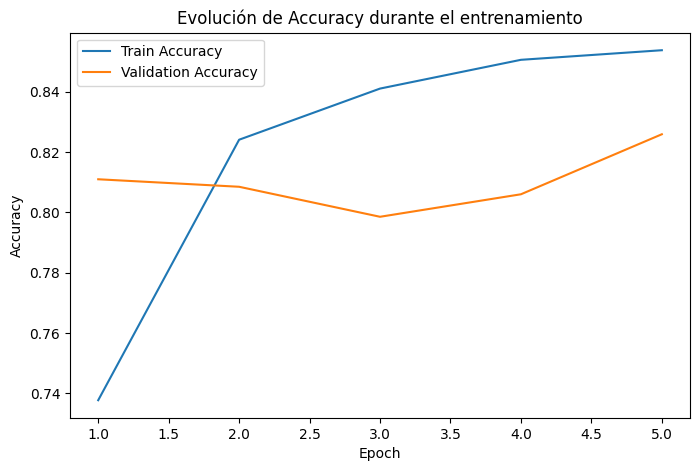

In [30]:
plot_train_results(history_EfficientNet_B5)

In [31]:
# EfficientNet-B0
acc_after_train, cm_after_train = evaluate_model(resnet50_ft, test_loader, device=device)
print("EfficientNet-B0 - Train Accuracy:", acc_after_train)
print("Confusion Matrix:\n", cm_after_train)




/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


EfficientNet-B0 - Train Accuracy: 0.9048780487804878
Confusion Matrix:
 [[144  15]
 [ 24 227]]


In [32]:
acc_after_train1, cm_after_train1 = evaluate_model(EfficientNet_B5_ft, test_loader, device=device)
print("EfficientNet-B0 - Train Accuracy:", acc_after_train1)
print("Confusion Matrix:\n", cm_after_train1)

/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/haru/Escritorio/TAVI/venv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


EfficientNet-B0 - Train Accuracy: 0.8341463414634146
Confusion Matrix:
 [[117  42]
 [ 26 225]]
